In [5]:
import os
import shutil
import tempfile
import matplotlib.pyplot as plt
import PIL
import torch
import numpy as np
from sklearn.metrics import classification_report
import glob
import pandas as pd

from monai.apps import download_and_extract
from monai.config import print_config
from monai.data import decollate_batch, DataLoader
from monai.metrics import ROCAUCMetric
from monai.networks.nets import DenseNet121
from monai.transforms import (
    Activations,
    EnsureChannelFirst,
    AsDiscrete,
    Compose,
    LoadImage,
    RandFlip,
    RandRotate,
    RandZoom,
    ScaleIntensity,
)
from monai.utils import set_determinism

print_config()

MONAI version: 0.9.dev2151
Numpy version: 1.19.5
Pytorch version: 1.10.1+cu102
MONAI flags: HAS_EXT = False, USE_COMPILED = False
MONAI rev id: 8bbc7c0eeceadae6b3d7a487b85068b4dc7e4899

Optional dependencies:
Pytorch Ignite version: NOT INSTALLED or UNKNOWN VERSION.
Nibabel version: NOT INSTALLED or UNKNOWN VERSION.
scikit-image version: 0.17.2
Pillow version: 8.4.0
Tensorboard version: 2.6.0
gdown version: NOT INSTALLED or UNKNOWN VERSION.
TorchVision version: 0.11.2+cu102
tqdm version: 4.64.1
lmdb version: NOT INSTALLED or UNKNOWN VERSION.
psutil version: NOT INSTALLED or UNKNOWN VERSION.
pandas version: 1.1.5
einops version: NOT INSTALLED or UNKNOWN VERSION.
transformers version: NOT INSTALLED or UNKNOWN VERSION.
mlflow version: NOT INSTALLED or UNKNOWN VERSION.

For details about installing the optional dependencies, please visit:
    https://docs.monai.io/en/latest/installation.html#installing-the-recommended-dependencies



In [3]:
data_path = '/cluster/home/taheeraa/datasets/chestxray-14'
image_files_list = []
for i in range(1, 13):
    folder_name = f'{data_path}/images_{i:03}'
    files_in_subfolder = glob.glob(f'{folder_name}/images/*')
    image_files_list.extend(files_in_subfolder)
print(f"Image paths: {len(image_files_list)}")
image_files_list

Image paths: 112120


['/cluster/home/taheeraa/datasets/chestxray-14/images_001/images/00000798_003.png',
 '/cluster/home/taheeraa/datasets/chestxray-14/images_001/images/00000181_029.png',
 '/cluster/home/taheeraa/datasets/chestxray-14/images_001/images/00000798_033.png',
 '/cluster/home/taheeraa/datasets/chestxray-14/images_001/images/00000697_008.png',
 '/cluster/home/taheeraa/datasets/chestxray-14/images_001/images/00000131_000.png',
 '/cluster/home/taheeraa/datasets/chestxray-14/images_001/images/00000540_001.png',
 '/cluster/home/taheeraa/datasets/chestxray-14/images_001/images/00000399_001.png',
 '/cluster/home/taheeraa/datasets/chestxray-14/images_001/images/00000165_002.png',
 '/cluster/home/taheeraa/datasets/chestxray-14/images_001/images/00000103_002.png',
 '/cluster/home/taheeraa/datasets/chestxray-14/images_001/images/00000449_003.png',
 '/cluster/home/taheeraa/datasets/chestxray-14/images_001/images/00001121_000.png',
 '/cluster/home/taheeraa/datasets/chestxray-14/images_001/images/00000102_00

In [25]:
df = pd.read_csv(f'{data_path}/Data_Entry_2017.csv')
# Add the image paths to the dataframe
df['Image Files List'] = image_files_list
# Create a new dataframe to store the image paths, labels, and patient IDs
df = df[['Image Files List', 'Finding Labels', 'Patient ID']]

# Make a list of all the labels
diseases = ['Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema', 'Effusion', 'Emphysema',
            'Fibrosis', 'Hernia', 'Infiltration', 'Mass', 'Nodule', 'Pleural_Thickening',
            'Pneumonia', 'Pneumothorax']

# For each label, make a new column and
# assign 1 if the disease is present and 0 if the disease is absent
for disease in diseases:
    df[disease] = df['Finding Labels'].apply(lambda x: 1 if disease in x else 0)
    
disease_mapping = {
    'Atelectasis': 0, 'Cardiomegaly': 1, 'Consolidation': 2, 'Edema': 3,
    'Effusion': 4, 'Emphysema': 5, 'Fibrosis': 6, 'Hernia': 7,
    'Infiltration': 8, 'Mass': 9, 'Nodule': 10, 'Pleural_Thickening': 11,
    'Pneumonia': 12, 'Pneumothorax': 13
}

# Function to get the first disease and map it
def map_disease_to_number(label):
    first_disease = label.split('|')[0]
    return disease_mapping.get(first_disease, -1)  # Returns -1 if disease not found

# Apply the function to create the new column
df['image_class'] = df['Finding Labels'].apply(map_disease_to_number)
df['finding_indicator'] = df['Finding Labels'].apply(lambda x: 0 if x == 'No Finding' else 1)
df.head()


,Image Files List,Finding Labels,Patient ID,Atelectasis,Cardiomegaly,Consolidation,Edema,Effusion,Emphysema,Fibrosis,Hernia,Infiltration,Mass,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax,image_class,finding_indicator
0,/cluster/home/taheeraa/datasets/chestxray-14/i...,Cardiomegaly,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,1
1,/cluster/home/taheeraa/datasets/chestxray-14/i...,Cardiomegaly|Emphysema,1,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1,1
2,/cluster/home/taheeraa/datasets/chestxray-14/i...,Cardiomegaly|Effusion,1,0,1,0,0,1,0,0,0,0,0,0,0,0,0,1,1
3,/cluster/home/taheeraa/datasets/chestxray-14/i...,No Finding,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,-1,0
4,/cluster/home/taheeraa/datasets/chestxray-14/i...,Hernia,3,0,0,0,0,0,0,0,1,0,0,0,0,0,0,7,1


,image_file,finding_indicator
0,/cluster/home/taheeraa/datasets/chestxray-14/i...,1
1,/cluster/home/taheeraa/datasets/chestxray-14/i...,1
2,/cluster/home/taheeraa/datasets/chestxray-14/i...,1
3,/cluster/home/taheeraa/datasets/chestxray-14/i...,0
4,/cluster/home/taheeraa/datasets/chestxray-14/i...,1
...,...,...
112115,/cluster/home/taheeraa/datasets/chestxray-14/i...,1
112116,/cluster/home/taheeraa/datasets/chestxray-14/i...,0
112117,/cluster/home/taheeraa/datasets/chestxray-14/i...,0
112118,/cluster/home/taheeraa/datasets/chestxray-14/i...,0


In [28]:
image_class = df['image_class'].tolist()
class_names = diseases
image_width, image_height = PIL.Image.open(image_files_list[0]).size
num_total = len(image_class)
num_class = len(class_names)

print(f"Total image count: {num_total}")
print(f"Image dimensions: {image_width} x {image_height}")
print(f"Label names: {class_names}")


Total image count: 112120
Image dimensions: 1024 x 1024
Label names: ['Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema', 'Effusion', 'Emphysema', 'Fibrosis', 'Hernia', 'Infiltration', 'Mass', 'Nodule', 'Pleural_Thickening', 'Pneumonia', 'Pneumothorax']


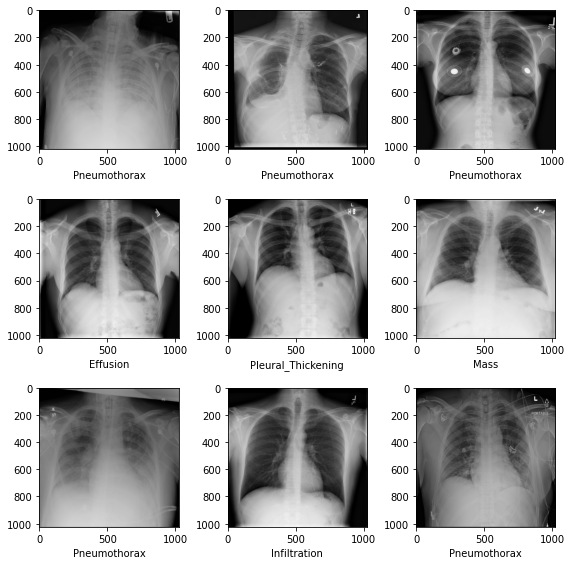

In [29]:
plt.subplots(3, 3, figsize=(8, 8))
for i, k in enumerate(np.random.randint(num_total, size=9)):
    im = PIL.Image.open(image_files_list[k])
    arr = np.array(im)
    plt.subplot(3, 3, i + 1)
    plt.xlabel(class_names[image_class[k]])
    plt.imshow(arr, cmap="gray", vmin=0, vmax=255)
plt.tight_layout()
plt.show()

# Binary classification

In [44]:
df = df[['image_file', 'finding_indicator']].rename(columns={'Image Files List': 'image_file'})
df.head()

,image_file,finding_indicator
0,/cluster/home/taheeraa/datasets/chestxray-14/i...,1
1,/cluster/home/taheeraa/datasets/chestxray-14/i...,1
2,/cluster/home/taheeraa/datasets/chestxray-14/i...,1
3,/cluster/home/taheeraa/datasets/chestxray-14/i...,0
4,/cluster/home/taheeraa/datasets/chestxray-14/i...,1


In [65]:
import os
import pandas as pd
from PIL import Image
from torchvision import transforms
from torch.utils.data import Dataset

class ChestXrayDatasetBinaryClass(Dataset):
    def __init__(self, df, transform=None):
        """
        Args:
            df (DataFrame): DataFrame with image paths and labels.
            transform (callable, optional): Optional transform to be applied on a sample.
        """
        self.df = df
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        img_name = os.path.join(self.df.iloc[idx]['image_file'])
        image = Image.open(img_name)
        label = self.df.iloc[idx, 1]

        if self.transform:
            image = self.transform(image)

        return image, label

# Your transform
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize to 224x224
    transforms.Grayscale(num_output_channels=3),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalizing for pre-trained models
])

In [66]:
df.head()

,image_file,finding_indicator
0,/cluster/home/taheeraa/datasets/chestxray-14/i...,1
1,/cluster/home/taheeraa/datasets/chestxray-14/i...,1
2,/cluster/home/taheeraa/datasets/chestxray-14/i...,1
3,/cluster/home/taheeraa/datasets/chestxray-14/i...,0
4,/cluster/home/taheeraa/datasets/chestxray-14/i...,1


In [67]:
from torch.utils.data import DataLoader

# Create the dataset
dataset = ChestXrayDatasetBinaryClass(df=df, transform=transform)

# Create a DataLoader
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

In [68]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models

class DenseNetBinaryClassifier(nn.Module):
    def __init__(self):
        super(DenseNetBinaryClassifier, self).__init__()
        # Load a pre-trained densenet
        self.densenet = models.densenet121(pretrained=True)
        
        # Replace classifier
        num_ftrs = self.densenet.classifier.in_features
        self.densenet.classifier = nn.Linear(num_ftrs, 1)

    def forward(self, x):
        return self.densenet(x)

# Create the model
model = DenseNetBinaryClassifier()
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [69]:
num_epochs= 1
for epoch in range(num_epochs):
    for inputs, labels in dataloader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

RuntimeError: [enforce fail at CPUAllocator.cpp:68] . DefaultCPUAllocator: can't allocate memory: you tried to allocate 102760448 bytes. Error code 12 (Cannot allocate memory)

# Monai

In [ ]:
val_frac = 0.1
test_frac = 0.1
length = len(image_files_list)
indices = np.arange(length)
np.random.shuffle(indices)

test_split = int(test_frac * length)
val_split = int(val_frac * length) + test_split
test_indices = indices[:test_split]
val_indices = indices[test_split:val_split]
train_indices = indices[val_split:]

train_x = [image_files_list[i] for i in train_indices]
train_y = [image_class[i] for i in train_indices]
val_x = [image_files_list[i] for i in val_indices]
val_y = [image_class[i] for i in val_indices]
test_x = [image_files_list[i] for i in test_indices]
test_y = [image_class[i] for i in test_indices]

print(f"Training count: {len(train_x)}, Validation count: " f"{len(val_x)}, Test count: {len(test_x)}")

In [69]:
train_transforms = Compose(
    [
        ScaleIntensity(),
        RandRotate(range_x=np.pi / 12, prob=0.5, keep_size=True),
        RandFlip(spatial_axis=0, prob=0.5),
        RandZoom(min_zoom=0.9, max_zoom=1.1, prob=0.5),
    ]
)

val_transforms = Compose([ScaleIntensity()])

y_pred_trans = Compose([Activations(softmax=True)])
y_trans = Compose([AsDiscrete(to_onehot=num_class)])


In [70]:
from PIL import Image
import numpy as np

class ChestXRay14(torch.utils.data.Dataset):
    def __init__(self, image_files, labels, transforms):
        self.image_files = image_files
        self.labels = labels
        self.transforms = transforms

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, index):
        # Load the image from the file path
        image_path = self.image_files[index]
        image = Image.open(image_path).convert('L')  # Convert to grayscale
        image = np.array(image)

        # Check if the image has only two dimensions (H, W)
        if len(image.shape) == 2:
            # Add a channel dimension (C, H, W)
            image = np.expand_dims(image, axis=0)

        # Apply the transforms
        image = self.transforms(image)

        return image, self.labels[index]


train_ds = ChestXRay14(train_x, train_y, train_transforms)
train_loader = DataLoader(train_ds, batch_size=300, shuffle=True, num_workers=10)

val_ds = ChestXRay14(val_x, val_y, val_transforms)
val_loader = DataLoader(val_ds, batch_size=300, num_workers=10)

test_ds = ChestXRay14(test_x, test_y, val_transforms)
test_loader = DataLoader(test_ds, batch_size=300, num_workers=10)

In [71]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = DenseNet121(spatial_dims=2, in_channels=1, out_channels=num_class).to(device)
loss_function = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), 1e-5)
max_epochs = 4
val_interval = 1
auc_metric = ROCAUCMetric()

In [72]:
best_metric = -1
best_metric_epoch = -1
epoch_loss_values = []
metric_values = []

for epoch in range(max_epochs):
    print("-" * 10)
    print(f"epoch {epoch + 1}/{max_epochs}")
    model.train()
    epoch_loss = 0
    step = 0
    for batch_data in train_loader:
        print(type(batch_data))
        step += 1
        inputs, labels = batch_data[0].to(device), batch_data[1].to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = loss_function(outputs, labels)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
        print(f"{step}/{len(train_ds) // train_loader.batch_size}, " f"train_loss: {loss.item():.4f}")
        epoch_len = len(train_ds) // train_loader.batch_size
    epoch_loss /= step
    epoch_loss_values.append(epoch_loss)
    print(f"epoch {epoch + 1} average loss: {epoch_loss:.4f}")

    if (epoch + 1) % val_interval == 0:
        model.eval()
        with torch.no_grad():
            y_pred = torch.tensor([], dtype=torch.float32, device=device)
            y = torch.tensor([], dtype=torch.long, device=device)
            for val_data in val_loader:
                val_images, val_labels = (
                    val_data[0].to(device),
                    val_data[1].to(device),
                )
                y_pred = torch.cat([y_pred, model(val_images)], dim=0)
                y = torch.cat([y, val_labels], dim=0)
            y_onehot = [y_trans(i) for i in decollate_batch(y, detach=False)]
            y_pred_act = [y_pred_trans(i) for i in decollate_batch(y_pred)]
            auc_metric(y_pred_act, y_onehot)
            result = auc_metric.aggregate()
            auc_metric.reset()
            del y_pred_act, y_onehot
            metric_values.append(result)
            acc_value = torch.eq(y_pred.argmax(dim=1), y)
            acc_metric = acc_value.sum().item() / len(acc_value)
            if result > best_metric:
                best_metric = result
                best_metric_epoch = epoch + 1
                torch.save(model.state_dict(), os.path.join(root_dir, "best_metric_model.pth"))
                print("saved new best metric model")
            print(
                f"current epoch: {epoch + 1} current AUC: {result:.4f}"
                f" current accuracy: {acc_metric:.4f}"
                f" best AUC: {best_metric:.4f}"
                f" at epoch: {best_metric_epoch}"
            )

print(f"Train completed, best_metric: {best_metric:.4f} " f"at epoch: {best_metric_epoch}")

----------
epoch 1/4

=== Transform input info -- RandRotate ===
Data statistics:
Type: <class 'numpy.ndarray'> float32
Shape: (1, 1024, 1024)
Value range: (0.0, 1.0)


Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7f2cf1f020b8>>
Traceback (most recent call last):
  File "/cluster/home/taheeraa/code/forprosjekt/.venv/lib64/python3.6/site-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/cluster/home/taheeraa/code/forprosjekt/.venv/lib64/python3.6/site-packages/torch/utils/data/dataloader.py", line 1301, in _shutdown_workers
    w.join(timeout=_utils.MP_STATUS_CHECK_INTERVAL)
  File "/usr/lib64/python3.6/multiprocessing/process.py", line 124, in join
    res = self._popen.wait(timeout)
  File "/usr/lib64/python3.6/multiprocessing/popen_fork.py", line 47, in wait
    if not wait([self.sentinel], timeout):
  File "/usr/lib64/python3.6/multiprocessing/connection.py", line 915, in wait
    ready = selector.select(timeout)
  File "/usr/lib64/python3.6/selectors.py", line 376, in select
    fd_event_list 

RuntimeError: can't start new thread